In [46]:
# Import all of the libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime as dt
%matplotlib inline 

from functools import reduce

In [44]:
# Upload datasets
data_customers = pd.read_csv('olist_customers_dataset.csv')
data_sellers = pd.read_csv('olist_sellers_dataset.csv')
data_order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
data_order_items = pd.read_csv('olist_order_items_dataset.csv')
data_products = pd.read_csv('olist_products_dataset.csv')
data_geolocation = pd.read_csv('olist_geolocation_dataset.csv')
data_translation = pd.read_csv('product_category_name_translation.csv')
data_orders = pd.read_csv('olist_orders_dataset.csv')
data_order_payments = pd.read_csv('olist_order_payments_dataset.csv')

In [47]:
#list with datasets with PK and FK 'order_id'
ordersList = [data_orders, data_order_items]

#merge, join multiple datasets with the same FK:
data = reduce(lambda data1, data2: pd.merge(data1, data2, on='order_id', how='left'), ordersList)

data = pd.merge(data, data_products, on='product_id', how='outer')

data = pd.merge(data, data_sellers, on='seller_id', how='outer')

#merge final data with the same FK (customer_id):
data = pd.merge(data, data_customers, on='customer_id', how='outer')

In [ ]:
data = data.merge(data_translation, on='product_category_name').drop('product_category_name', axis=1)

In [53]:
data.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,9350.0,maua,SP,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,9350.0,maua,SP,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,9350.0,maua,SP,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,9350.0,maua,SP,e781fdcc107d13d865fc7698711cc572,88032,florianopolis,SC
4,8736140c61ea584cb4250074756d8f3b,ab8844663ae049fda8baf15fc928f47f,delivered,2017-08-10 13:35:55,2017-08-10 13:50:09,2017-08-11 13:52:35,2017-08-16 19:03:36,2017-08-23 00:00:00,1.0,b00a32a0b42fd65efb58a5822009f629,...,20.0,10.0,15.0,9350.0,maua,SP,02c9e0c05a817d4562ec0e8c90f29dba,8577,itaquaquecetuba,SP


## EDA- Exploratory Data Analysis

- Created a single dataset for OLAP by denormalization in order to analyze with more performance.
- Lets look into the dataset


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113425 entries, 0 to 113424
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113425 non-null  object 
 1   customer_id                    113425 non-null  object 
 2   order_status                   113425 non-null  object 
 3   order_purchase_timestamp       113425 non-null  object 
 4   order_approved_at              113264 non-null  object 
 5   order_delivered_carrier_date   111457 non-null  object 
 6   order_delivered_customer_date  110196 non-null  object 
 7   order_estimated_delivery_date  113425 non-null  object 
 8   order_item_id                  112650 non-null  float64
 9   product_id                     112650 non-null  object 
 10  seller_id                      112650 non-null  object 
 11  shipping_limit_date            112650 non-null  object 
 12  price                         

In [65]:
data.loc[(data.order_delivered_customer_date.isna())&((data.order_status == 'shipped')) ]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
176,1b1d6a3f8e1369c613eb19c40dab5624,e8c7b1e1584d6ba2f13473ac8e3e7cbe,shipped,2018-03-13 20:56:03,2018-03-13 21:10:31,2018-03-14 20:03:34,NaN,2018-04-04 00:00:00,1.0,5cbca81261e661159b5a3e6025bffba8,...,19.0,13.0,17.0,31570.0,belo horizonte,SP,f19e328e47fd205fba41312020a92771,12850,bananal,SP
235,3a53d5a9a0c58d291ff3ae407b6df5fd,5612aa60cdbbd8e9d89ae0c409080375,shipped,2018-02-16 21:55:03,2018-02-17 01:26:58,2018-02-19 16:14:14,NaN,2018-03-14 00:00:00,1.0,595fac2a385ac33a80bd5114aec74eb8,...,19.0,13.0,19.0,24451.0,sao goncalo,RJ,43ffa7da9e5e738684a2d571602b5bc5,94470,viamao,RS
339,72c501775cf36e99076132aaee5ae9c0,6cc8f025e1b94225a79f478d3bcba65c,shipped,2017-12-01 12:39:39,2017-12-02 02:37:10,2017-12-04 20:39:56,NaN,2017-12-19 00:00:00,1.0,595fac2a385ac33a80bd5114aec74eb8,...,19.0,13.0,19.0,9020.0,santo andre,SP,9f0628912b8102be6ef4638d0753addf,6714,cotia,SP
443,37726a8b1cbcf77034870df2521be6f6,2976ca9e434924142eca1be125f4653b,shipped,2018-03-07 10:06:01,2018-03-07 10:15:51,2018-03-08 18:17:02,NaN,2018-03-28 00:00:00,1.0,7a10781637204d8d10485c71a6108a2e,...,18.0,13.0,15.0,14840.0,guariba,SP,a05dfc86f74cf1ae98a82ebcc628cbb5,29090,vitoria,ES
489,75687059537f4b53423dc1d645c6822f,239e040dfb9ecf20be36947bbea5fa0f,shipped,2018-02-28 21:28:33,2018-02-28 21:48:26,2018-03-03 00:05:26,NaN,2018-03-19 00:00:00,1.0,7a10781637204d8d10485c71a6108a2e,...,18.0,13.0,15.0,14840.0,guariba,SP,2fc1f00a492a9ebbbbadc1b5e3a540e5,9175,santo andre,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113025,48a310c40917683b0b399849b50cb76f,5b54155ba8103b1bb1e157edc0d85fe7,shipped,2017-02-24 13:50:32,2017-02-25 02:22:39,2017-03-01 04:37:47,NaN,2017-03-31 00:00:00,2.0,bf99dbe84781cda5b1fc4f926d10dc1b,...,26.0,9.0,36.0,6753.0,taboao da serra,SP,12b5c7a4537f86e5e1490e32ff9a3ded,64080,teresina,PI
113186,5d4503ba682b806ff232782327b7bd7f,24faa20dd67cdb36a1efd90ca3d84550,shipped,2017-11-14 06:00:37,2017-11-15 02:46:53,2017-11-16 19:15:50,NaN,2017-12-07 00:00:00,1.0,bf5fe03d1ac5be6407a279b3681992ed,...,22.0,22.0,22.0,2880.0,sao paulo,SP,f67fc1386bc8c7ec87ecfa39c552dcd9,35400,ouro preto,MG
113205,369d4391cc475b184da61af43967f197,71ac7ff106160c3efd7f1fe76ddb461e,shipped,2018-06-05 19:06:38,2018-06-05 19:54:42,2018-06-07 13:04:00,NaN,2018-07-19 00:00:00,1.0,1f459c80ec206dc814560de10182cdaf,...,18.0,14.0,17.0,88870.0,orleans,SC,2ad5c989cdbc90ca393b3b3cd2cdc19b,45816,arraial d'ajuda,BA
113219,94b85615d0bf9757c6a3b1a20be1a9cf,5738d0a3932e3ae32a2169b9040e5c0b,shipped,2018-05-14 09:17:04,2018-05-14 09:32:25,2018-05-17 14:11:00,NaN,2018-06-04 00:00:00,1.0,0c08876047d07cc4448ba14159a454e7,...,20.0,10.0,15.0,37540.0,santa rita do sapucai,MG,35a1e3dc12ca1b9f2fca417827fd6183,86600,rolandia,PR


In [51]:
# Looking into the quantity of NaN which can effect the performance of our analysis 

data_miss = pd.concat([data.isna().sum().sort_values(ascending = False),
                       ((data.isna().sum()/data.isna().count())*100).sort_values(ascending = False),
                       data.dtypes], axis=1, keys=['Total_Missing', 'Missing_%', 'Type'])

data_miss[data_miss['Total_Missing'] > 0]

,Total_Missing,Missing_%,Type
order_delivered_customer_date,3229,2.846815,object
product_category_name,2378,2.096540,object
product_photos_qty,2378,2.096540,float64
product_description_lenght,2378,2.096540,float64
product_name_lenght,2378,2.096540,float64
order_delivered_carrier_date,1968,1.735067,object
product_width_cm,793,0.699140,float64
product_height_cm,793,0.699140,float64
product_length_cm,793,0.699140,float64
product_weight_g,793,0.699140,float64


As discussed in the description of the data set, the data model was original had different relationships. A single purchase can contain multiple products, multiple forms of payments and/or multiple sellers. The order_id is not a primary key. We need to calculate averages considering the value of unique sales.  

In [61]:
totalOrders = data_orders.order_id.nunique()

print('Summary of Brazilian E-Commerce')
print('Avg Price:', data.price.sum()/ totalOrders)
print('Avg Quantity of Products by Order:', data.order_item_id.sum()/ totalOrders)
print('Avg Freight Price:', data.freight_value.sum()/ totalOrders)
print('---------------------------------------------------------------------------')
print('Unique Customer :', data.customer_unique_id.nunique())
print('Unique Customer Cities:', data.customer_city.nunique())
print('Unique Customer States:', data.customer_state.nunique())
print('Unique Seller States:', data.seller_state.nunique())
print('---------------------------------------------------------------------------')
print('Total Revenue:', data.price.sum())
print('Total Order Quantity:', totalOrders)

Summary of Brazilian E-Commerce
Avg Price: 136.68048088816482
Avg Quantity of Products by Order: 1.3569453243631902
Avg Freight Price: 22.64568477790851
---------------------------------------------------------------------------
Unique Customer : 96096
Unique Customer Cities: 4119
Unique Customer States: 27
Unique Seller States: 23
---------------------------------------------------------------------------
Total Revenue: 13591643.7
Total Order Quantity: 99441


count    99441.000000
mean       136.680481
std        210.172081
min          0.000000
25%         45.000000
50%         85.000000
75%        149.900000
max      13440.000000
Name: price, dtype: float64
count    112650.000000
mean        120.653739
std         183.633928
min           0.850000
25%          39.900000
50%          74.990000
75%         134.900000
max        6735.000000
Name: price, dtype: float64


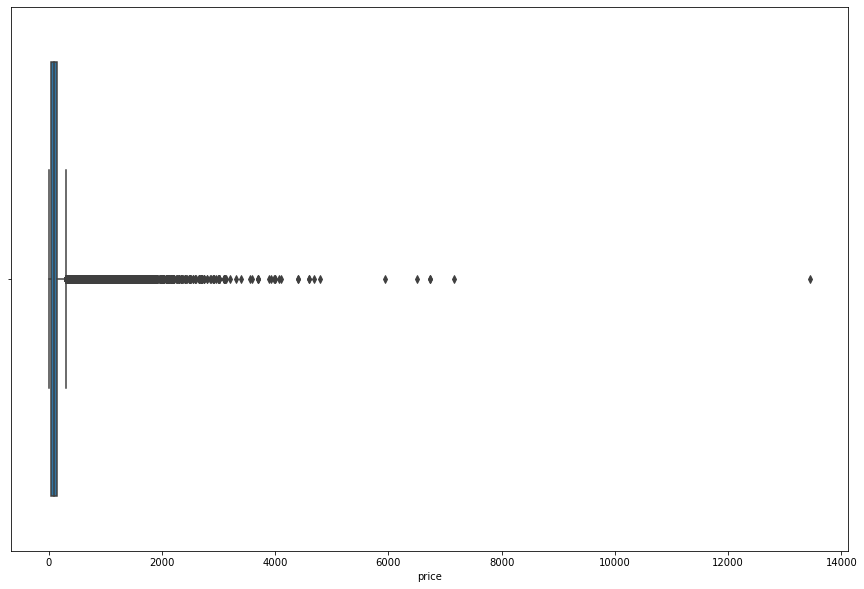

In [75]:
#Evaluating price distribution
plt.figure(figsize=(15,10))
sns.boxplot(x=data.groupby('order_id')['price'].sum())
print(data.groupby('order_id')['price'].sum().describe())
print(data['price'].describe())

In [70]:
print(data.groupby('order_id')['price'].sum().sort_values(ascending=False).head(10))

order_id
03caa2c082116e1d31e67e9ae3700499    13440.0
736e1922ae60d0d6a89247b851902527     7160.0
0812eb902a67711a1cb742b3cdaa65ae     6735.0
fefacc66af859508bf1a7934eab1e97f     6729.0
f5136e38d1a14a4dbd87dff67da82701     6499.0
2cc9089445046817a7539d90805e6e5a     5934.6
a96610ab360d42a2e5335a3998b4718a     4799.0
199af31afc78c699f0dbf71fb178d4d4     4690.0
b4c4b76c642808cbe472a32b86cddc95     4599.9
8dbc85d1447242f3b127dda390d56e19     4590.0
Name: price, dtype: float64


In [73]:
data.loc[data['order_id']=='03caa2c082116e1d31e67e9ae3700499']['price']

108988    1680.0
108989    1680.0
108990    1680.0
108991    1680.0
108992    1680.0
108993    1680.0
108994    1680.0
108995    1680.0
Name: price, dtype: float64

In [74]:
# In future work I would like to perform similar analysis but by binning through prices and compared the differences btw high ticket products vs smaller

<AxesSubplot:title={'center':'Total Price By State (R$)'}, xlabel='customer_state', ylabel='price'>

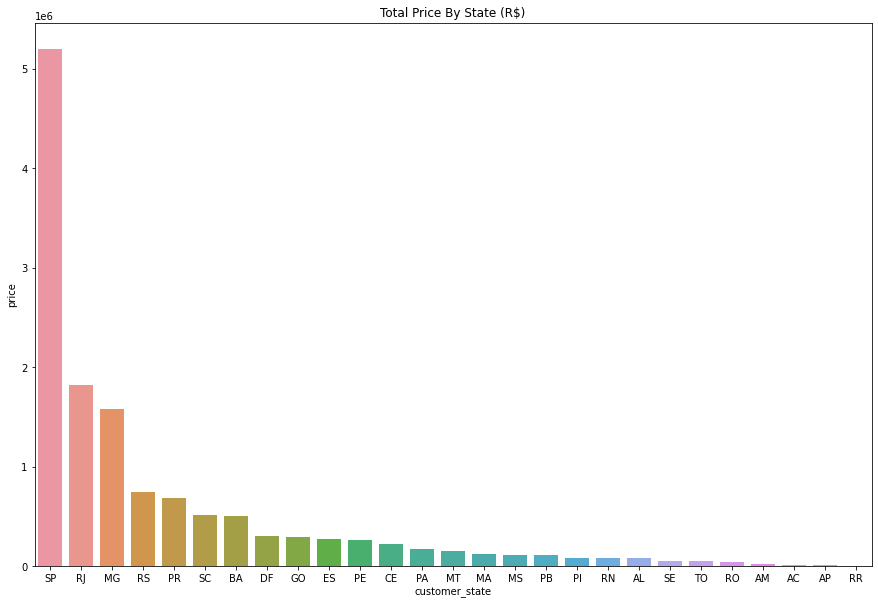

In [66]:
# Total Price by State
plt.figure(figsize=(15,10))
plt.title('Total Price By State (R$)')
sns.barplot(x=data.groupby('customer_state')['price'].sum().sort_values(ascending=False).index,
            y=data.groupby('customer_state')['price'].sum().sort_values(ascending=False))

<AxesSubplot:title={'center':'Total Seller Counts By State'}, xlabel='seller_state', ylabel='order_id'>

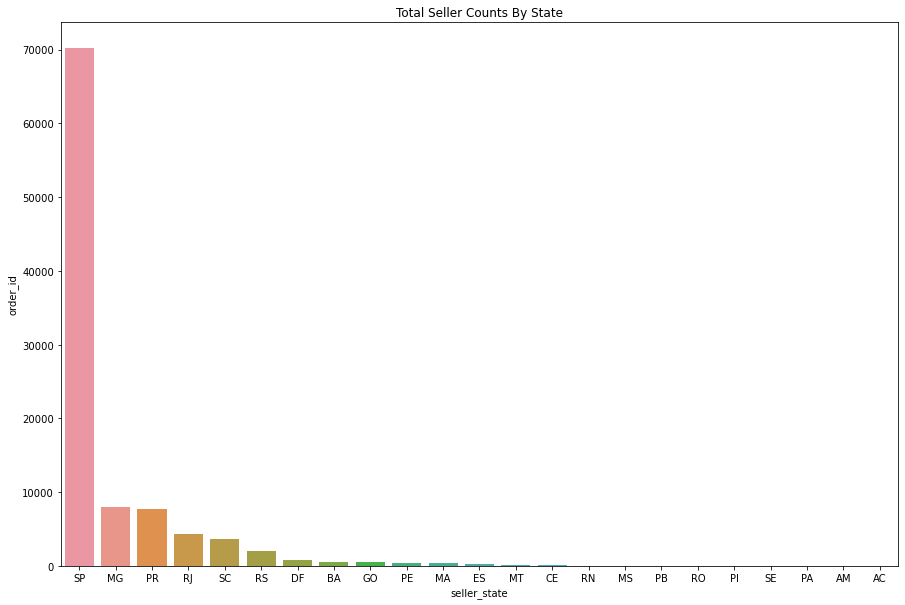

In [67]:
# Total Price by State
plt.figure(figsize=(15,10))
plt.title('Total Seller Counts By State')
sns.barplot(x=data.groupby('seller_state')['order_id'].nunique().sort_values(ascending=False).index,
            y=data.groupby('seller_state')['order_id'].nunique().sort_values(ascending=False))

Based on the average freight value by State we can begin to understand why the State SP has a high number of sellers. With the lowest freight value you can expect more return by reducing your delivery cost. 

<AxesSubplot:title={'center':'Average freight value in R$ by State of the Customer'}, xlabel='customer_state'>

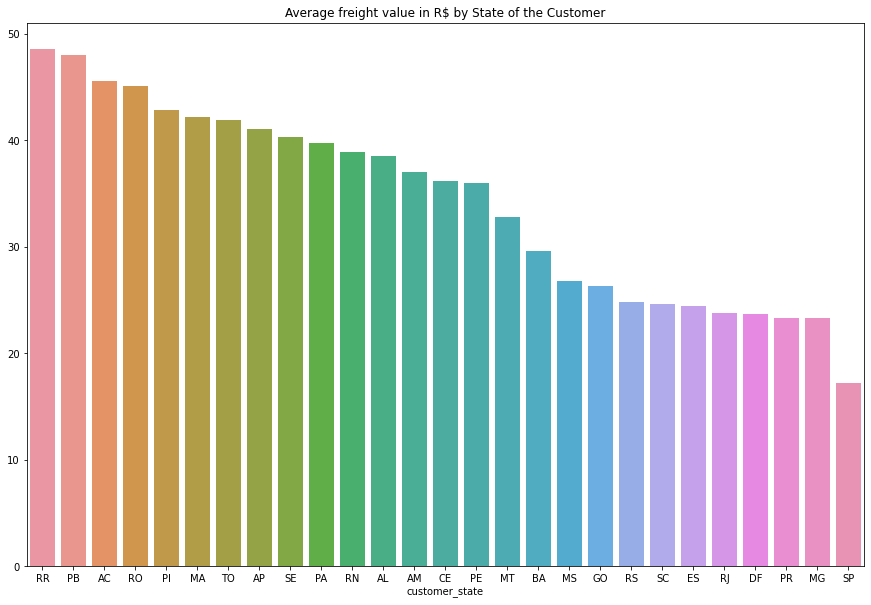

In [76]:
freightAvgState = (data.groupby('customer_state')['freight_value'].sum() /data.groupby('customer_state')['order_id'].nunique()).sort_values(ascending=False)

plt.figure(figsize=(15,10))
plt.title('Average freight value in R$ by State of the Customer')
sns.barplot(x=freightAvgState.index, y=freightAvgState)

## Data Science
- Clustering
- Clasification
- Time Series

In [10]:
# Downloading data 

order_list = pd.read_csv('olist_public_dataset_v2.csv/olist_public_dataset_v2.csv')

# converting to datetime
order_list['order_purchase_timestamp'] = pd.to_datetime(order_list.order_purchase_timestamp)
order_list['order_aproved_at'] = pd.to_datetime(order_list.order_aproved_at).dt.date  
order_list['order_estimated_delivery_date'] = pd.to_datetime(order_list.order_estimated_delivery_date).dt.date  
order_list['order_delivered_customer_date'] = pd.to_datetime(order_list.order_delivered_customer_date).dt.date 

# Merge translation for category names
translation = pd.read_csv('product_category_name_translation.csv')

order_list = order_list.merge(translation, on='product_category_name').drop('product_category_name', axis=1)

order_list.head(3)

,order_id,order_status,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,order_delivered_customer_date,...,product_description_lenght,product_photos_qty,product_id,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name_english
0,b95df3cef5297e79ef709ba256518f6f,delivered,349.90,13.84,1,1,2017-01-31 17:19:01,2017-02-01,2017-03-15,2017-02-06,...,625,1,6cdd53843498f92890544667809f1595,b95df3cef5297e79ef709ba256518f6f,5,NaN,NaN,2017-02-07 00:00:00.000000,2017-02-09 02:37:37+00:00,health_beauty
1,e98077a0d199a25a40eab3b14cc230d4,delivered,39.99,15.23,1,2,2018-04-17 13:25:36,2018-04-18,2018-05-10,2018-04-27,...,405,2,190d9562bfbe9d3ed876c2ac6f2f5894,e98077a0d199a25a40eab3b14cc230d4,5,NaN,NaN,2018-04-28 00:00:00.000000,2018-04-29 21:07:53+00:00,health_beauty
2,8a723730400b508cbf47fbef4a76ec8e,delivered,60.00,20.91,1,1,2018-02-18 12:41:01,2018-02-18,2018-03-14,2018-03-03,...,1665,1,5858f45c20fde7d7e49af37a2166635a,8a723730400b508cbf47fbef4a76ec8e,5,NaN,muito bom cabelo fica lisinho,2018-03-04 00:00:00.000000,2018-03-07 02:53:50+00:00,health_beauty


In [11]:
order_list.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       100000 non-null  object        
 1   order_status                   100000 non-null  object        
 2   order_products_value           100000 non-null  float64       
 3   order_freight_value            100000 non-null  float64       
 4   order_items_qty                100000 non-null  int64         
 5   order_sellers_qty              100000 non-null  int64         
 6   order_purchase_timestamp       100000 non-null  datetime64[ns]
 7   order_aproved_at               99982 non-null   object        
 8   order_estimated_delivery_date  100000 non-null  object        
 9   order_delivered_customer_date  97595 non-null   object        
 10  customer_id                    100000 non-null  object        
 11  c

For the sake of testing our Hypothesis we will remove written reviews made by the customer.

In [12]:
#Removing columns that are repetative and do not add unique value to model.
#Removing written reviews as it will not help us create a model that will predict customer satisfaction.
order_list = order_list.drop(['customer_id', 'customer_city', 'customer_zip_code_prefix',
                              'product_id',
                              'review_id', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp' ], axis=1)

In [13]:
order_list.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       100000 non-null  object        
 1   order_status                   100000 non-null  object        
 2   order_products_value           100000 non-null  float64       
 3   order_freight_value            100000 non-null  float64       
 4   order_items_qty                100000 non-null  int64         
 5   order_sellers_qty              100000 non-null  int64         
 6   order_purchase_timestamp       100000 non-null  datetime64[ns]
 7   order_aproved_at               99982 non-null   object        
 8   order_estimated_delivery_date  100000 non-null  object        
 9   order_delivered_customer_date  97595 non-null   object        
 10  customer_state                 100000 non-null  object        
 11  p

In [26]:
order_list.dropna(inplace=True)
order_list.head(10)

,order_id,order_status,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,order_delivered_customer_date,customer_state,product_name_lenght,product_description_lenght,product_photos_qty,review_score,product_category_name_english
0,b95df3cef5297e79ef709ba256518f6f,delivered,349.90,13.84,1,1,2017-01-31 17:19:01,2017-02-01,2017-03-15,2017-02-06,PR,51,625,1,5,health_beauty
1,e98077a0d199a25a40eab3b14cc230d4,delivered,39.99,15.23,1,2,2018-04-17 13:25:36,2018-04-18,2018-05-10,2018-04-27,DF,51,405,2,5,health_beauty
2,8a723730400b508cbf47fbef4a76ec8e,delivered,60.00,20.91,1,1,2018-02-18 12:41:01,2018-02-18,2018-03-14,2018-03-03,MG,38,1665,1,5,health_beauty
3,cf71b9b6b7ed12d72f541b0420023f19,delivered,79.99,10.94,1,1,2018-05-09 23:33:28,2018-05-11,2018-05-24,2018-05-17,ES,59,492,3,4,health_beauty
4,93ef9253c47e7dfc633c01f728488cb1,delivered,58.99,11.73,1,1,2017-10-26 09:07:04,2017-10-27,2017-11-09,2017-10-31,SP,59,492,2,4,health_beauty
5,35bc592a16d6706d14d29f07ed1d13c1,delivered,639.00,21.40,1,1,2018-08-11 15:41:42,2018-08-11,2018-08-28,2018-08-22,RJ,59,2141,1,5,health_beauty
6,e7769dad49f530a8ef12ff975719c27f,delivered,23.99,7.78,1,1,2017-10-18 20:26:10,2017-10-18,2017-11-03,2017-10-23,SP,48,575,1,5,health_beauty
7,bf84e0afb917b54c4a95b9497c4881fb,delivered,219.00,15.70,1,1,2017-03-04 14:15:02,2017-03-04,2017-03-27,2017-03-13,SP,42,1607,3,5,health_beauty
8,288cd0aca6f66df79aab71d94c1caad7,delivered,29.90,12.87,1,1,2018-07-15 22:07:27,2018-07-17,2018-07-31,2018-07-20,SP,58,391,1,4,health_beauty
9,38f84a21226e448e6ca37b3c45144994,delivered,55.90,11.73,1,1,2018-02-09 13:46:39,2018-02-09,2018-02-23,2018-02-16,SP,55,1297,1,5,health_beauty


In [30]:
order_list = order_list.reset_index(drop=True)

In [31]:
order_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97578 entries, 0 to 97577
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       97578 non-null  object        
 1   order_status                   97578 non-null  object        
 2   order_products_value           97578 non-null  float64       
 3   order_freight_value            97578 non-null  float64       
 4   order_items_qty                97578 non-null  int64         
 5   order_sellers_qty              97578 non-null  int64         
 6   order_purchase_timestamp       97578 non-null  datetime64[ns]
 7   order_aproved_at               97578 non-null  object        
 8   order_estimated_delivery_date  97578 non-null  object        
 9   order_delivered_customer_date  97578 non-null  object        
 10  customer_state                 97578 non-null  object        
 11  product_name_le

In [32]:
# Preparing the data: Splitting the Data
# Split data in a way to keep the distribustion of unique review_score
# Current review_score distribution
order_list['review_score'].value_counts()/len(order_list['review_score'])

5    0.578512
4    0.195792
1    0.104726
3    0.087643
2    0.033327
Name: review_score, dtype: float64

In [33]:
# Create a 80/20 split & keep review_score distribution
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(order_list, order_list['review_score']):
    strat_train_set = order_list.loc[train_index]
    strat_test_set = order_list.loc[test_index]

In [34]:
# Better represents the origianl data 
strat_train_set['review_score'].value_counts()/len(strat_train_set['review_score'])

5    0.578515
4    0.195793
1    0.104724
3    0.087635
2    0.033332
Name: review_score, dtype: float64

In [35]:
# Sperating features and target
orders_features = strat_train_set.drop('review_score', axis=1)
orders_target = strat_train_set['review_score'].copy()

In [36]:
# Check if current features are strong predictors. Check correalations
corr_matrix = strat_train_set.corr()
corr_matrix['review_score'].sort_values(ascending=False)

review_score                  1.000000
product_description_lenght    0.017224
product_photos_qty            0.016595
product_name_lenght          -0.011663
order_products_value         -0.014448
order_freight_value          -0.069303
order_items_qty              -0.079721
order_sellers_qty            -0.148409
Name: review_score, dtype: float64

### Feature Engineering 


In [37]:
# Create a class to transform new/unseen data

from sklearn.base import BaseEstimator, TransformerMixin

class FeaturesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        df = X.copy()
        
        
        df['wd_est_delivery_time'] = df.apply(lambda x: cal.get_working_days_delta(x.order_aproved_at, x.order_estimated_delivery_date), axis=1)
        df['wd_act_delivery_time'] = df.apply(lambda x: cal.get_working_days_delta(x.order_aproved_at, x.order_delivered_customer_date), axis=1)
        df['wd_delivery_delta'] = df.wd_act_delivery_time - df.wd_est_delivery_time
        
        df['late'] = df.order_delivered_customer_date > df.order_estimated_delivery_date
        
        df['average_product_value'] = df.order_products_value/df.order_items_qty
        
        df['total_order_value'] = df.order_products_value + df.order_freight_value
        
        df['order_freight_ratio'] = df.order_freight_value / df.order_products_value
        
        df['purchase_dayofweek'] = df.order_purchase_timestamp.dt.dayofweek
        
        cols2drop = ['order_purchase_timestamp', 'order_aproved_at',
                     'order_estimated_delivery_date', 'order_delivered_customer_date']
        df.drop(cols2drop, axis=1, inplace=True)
        
        return df
        

In [38]:
# To consider Brazilian calendar and holidays
!pip install workalendar
from workalendar.america import Brazil
cal = Brazil()

You should consider upgrading via the 'c:\users\egust\anaconda3\python.exe -m pip install --upgrade pip' command.


In [39]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78062 entries, 22831 to 91046
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       78062 non-null  object        
 1   order_status                   78062 non-null  object        
 2   order_products_value           78062 non-null  float64       
 3   order_freight_value            78062 non-null  float64       
 4   order_items_qty                78062 non-null  int64         
 5   order_sellers_qty              78062 non-null  int64         
 6   order_purchase_timestamp       78062 non-null  datetime64[ns]
 7   order_aproved_at               78062 non-null  object        
 8   order_estimated_delivery_date  78062 non-null  object        
 9   order_delivered_customer_date  78062 non-null  object        
 10  customer_state                 78062 non-null  object        
 11  product_nam

In [40]:
attr_adder = FeaturesAdder()
feat_eng = attr_adder.transform(strat_train_set)
feat_eng.head(3)

,order_id,order_status,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,customer_state,product_name_lenght,product_description_lenght,product_photos_qty,review_score,product_category_name_english,wd_est_delivery_time,wd_act_delivery_time,wd_delivery_delta,late,average_product_value,total_order_value,order_freight_ratio,purchase_dayofweek
22831,c2cbad19d26c3e399c065fb573a6611c,delivered,56.99,12.74,1,1,SP,50,405,1,4,bed_bath_table,16,5,-11,False,56.99,69.73,0.223548,0
70860,9b7fd5b0ef330dcbbb6397e5971faeec,delivered,39.00,15.10,1,1,SP,49,709,5,1,fixed_telephony,16,8,-8,False,39.00,54.10,0.387179,2
84300,41909874350310b0492ec7b4b889f879,delivered,199.00,17.64,1,1,PR,48,330,1,5,cool_stuff,23,12,-11,False,199.00,216.64,0.088643,4


In [41]:
# Check if new features are strong predictors. Check correalations
corr_matrix = feat_eng.corr()
corr_matrix['review_score'].sort_values(ascending=False)

review_score                  1.000000
product_description_lenght    0.017224
product_photos_qty            0.016595
average_product_value         0.003460
purchase_dayofweek           -0.006167
product_name_lenght          -0.011663
order_products_value         -0.014448
total_order_value            -0.020583
order_freight_ratio          -0.024641
wd_est_delivery_time         -0.046549
order_freight_value          -0.069303
order_items_qty              -0.079721
order_sellers_qty            -0.148409
wd_delivery_delta            -0.247254
wd_act_delivery_time         -0.309535
late                         -0.367666
Name: review_score, dtype: float64

## Buisness Problem

- Need to address serious negative reviews
- Need to predict customer satisfaction
- To predict review(+VE or -VE) of a customer on thier next purchase, given historical data. 